# Build Model ANN

### **Import Libraries**

In [231]:
# library dataframe
import pandas as pd
# library olah data numerical
import numpy as np

# Data visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# libraries Data Preprocessing
from sklearn.model_selection import train_test_split # splitting data
from feature_engine.outliers import Winsorizer # outlier
from sklearn.preprocessing import StandardScaler, MinMaxScaler # scalling
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder # encoder
from sklearn.impute import SimpleImputer # imputer missing value

# sampling
from imblearn.over_sampling import SMOTE # over-sample

# Pipeline
from sklearn.pipeline import Pipeline # pipeline
from imblearn.pipeline import Pipeline as ImbPipeline # pipeline balanced data
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier

# Evaluasi model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score

# ----------------------------------------------#
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# tuning model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


# Save model
import joblib
import json
import os

# utils
from collections import Counter
from pprint import pprint as pprint

# Library to suppress warnings or deprecation notes
import warnings
warnings.filterwarnings('ignore')

In [157]:
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout,  BatchNormalization
from keras.initializers import HeNormal, GlorotUniform
from keras.regularizers import l2


print(tf.__version__)

2.13.0


## Load Data

In [158]:
data = pd.read_csv('data/bank_marketing.csv', sep=';', na_values='unknown')

data

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


## Data cleaning

In [159]:
# hapus data duplikat yang terakhir
data.drop_duplicates(keep='first', inplace=True)

In [160]:
# Ubah nama kolom
data.columns = data.columns.str.lower().str.replace(' ', '_')
data.columns = data.columns.str.replace('.', '_')

In [161]:
# Ubah 'duration' ke menit
data['duration'] = data['duration'] / 60  # Mengubah detik ke menit

In [162]:
category_feature = data.select_dtypes(include=['object', 'category'])

for col in category_feature:
    print(f"{col} : {data[col].unique()}")

job : ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' nan 'entrepreneur' 'student']
marital : ['married' 'single' 'divorced' nan]
education : ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course' nan
 'university.degree' 'illiterate']
default : ['no' nan 'yes']
housing : ['no' 'yes' nan]
loan : ['no' 'yes' nan]
contact : ['telephone' 'cellular']
month : ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week : ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome : ['nonexistent' 'failure' 'success']
y : ['no' 'yes']


In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             40846 non-null  object 
 2   marital         41096 non-null  object 
 3   education       39446 non-null  object 
 4   default         32580 non-null  object 
 5   housing         40186 non-null  object 
 6   loan            40186 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  float64
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp_var_rate    41176 non-null  float64
 16  cons_price_idx  41176 non-null  float64
 17  cons_conf_idx   41176 non-null  floa

# Feature Engineering

### Spliting Data

In [164]:
# split feature and label
X = data.drop('y', axis=1)
y = data['y'].map({'no':0, 'yes':1})

In [165]:
seed = 42
np.random.seed(seed)

# Split train-validation and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
# Split tran and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed)

Train set 70%  
Validation set 15%  
test set 15%  

In [166]:
print('Shape X_train:', X_train.shape)
print('Shape y_train:', y_train.shape)

print('Shape X_test:', X_test.shape)
print('Shape y_test:', y_test.shape)

print('Shape X_val:', X_val.shape)
print('Shape y_val:', y_val.shape)

Shape X_train: (29749, 20)
Shape y_train: (29749,)
Shape X_test: (6177, 20)
Shape y_test: (6177,)
Shape X_val: (5250, 20)
Shape y_val: (5250,)


### Missing value checking

In [167]:
## kita tau data "unknown" adalah missing value MCAR
# buat data "unknown" ke nan agar terbaca oleh pandas
X_train.replace("unknown",np.nan,inplace=True)
X_test.replace("unknown",np.nan,inplace=True)
X_val.replace("unknown",np.nan,inplace=True)

In [168]:
X_train.isna().sum()

age                  0
job                254
marital             56
education         1260
default           6255
housing            707
loan               707
contact              0
month                0
day_of_week          0
duration             0
campaign             0
pdays                0
previous             0
poutcome             0
emp_var_rate         0
cons_price_idx       0
cons_conf_idx        0
euribor3m            0
nr_employed          0
dtype: int64

In [169]:
# impute missing value
cols_impute = ['job', 'marital', 'education', 'default', 'housing', 'loan']

for col in cols_impute:

  X_train[col].fillna(X_train[col].mode()[0], inplace=True)
  X_test[col].fillna(X_train[col].mode()[0], inplace=True)
  X_val[col].fillna(X_train[col].mode()[0], inplace=True)

In [170]:
print(f'Missing Values Training : {X_train.isna().sum().sum()}')
print(f'Missing Values Test: {X_test.isnull().sum().sum()}')
print(f'Missing Values Validation: {X_val.isnull().sum().sum()}')

Missing Values Training : 0
Missing Values Test: 0
Missing Values Validation: 0


### Handling outlier

In [171]:
# handling outlier
def handling_outlier_wisorized(X_train, X_test, X_val,cols_outlier):
  #cek data normal dan tidak normal
  list_cols_normal = []
  list_cols_Not_normal = []

  for col in X[cols_outlier]:

    skew = X_train[col].skew()
    kurtosis = X_train[col].kurt()

    if -0.5 < skew < 0.5 or kurtosis < 3:
      list_cols_normal.append(col)
      
    else:
      list_cols_Not_normal.append(col)

  # handling outlier
  winsorizer_normal_dist = Winsorizer(capping_method='gaussian',
                                      tail='both',
                                      fold=3,
                                      variables=list_cols_normal,
                                      missing_values='ignore')

  winsorizer_not_normal_dist = Winsorizer(capping_method='iqr',
                                 tail='both',
                                 fold=1.5,
                                 variables=list_cols_Not_normal,
                                 missing_values='ignore')

  X_train_capped = winsorizer_normal_dist.fit_transform(X_train)
  X_test_capped = winsorizer_normal_dist.transform(X_test)
  X_val_capped = winsorizer_normal_dist.transform(X_val)


  X_train_capped = winsorizer_not_normal_dist.fit_transform(X_train_capped)
  X_test_capped = winsorizer_not_normal_dist.transform(X_test_capped)
  X_val_capped = winsorizer_not_normal_dist.transform(X_val_capped)

  return X_train_capped, X_test_capped, X_val_capped


In [172]:
# handling outlier
cols_outlier = ['age',
 'duration',
 'campaign',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']


X_train_capped, X_test_capped, X_val_capped = handling_outlier_wisorized(X_train, X_test, X_val,cols_outlier)

In [173]:
# Plot Distribution Comparison
def outlier_handling_plot_comparison(df_before, df_after, variable):
    """
    This function is created to plot histograms and boxplots for a variable before and after outlier handling

    Parameters:
    - df_before (pandas.DataFrame): DataFrame before outlier handling
    - df_after (pandas.DataFrame): DataFrame after outlier handling
    - variable (str): The variable to plot

    Example:
    num_cols = ['numeric_column']                                   <- Enter the numeric column
    for col in num_cols:                                            <- make a for loop in numeric column to access every columns
        plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

    """
    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

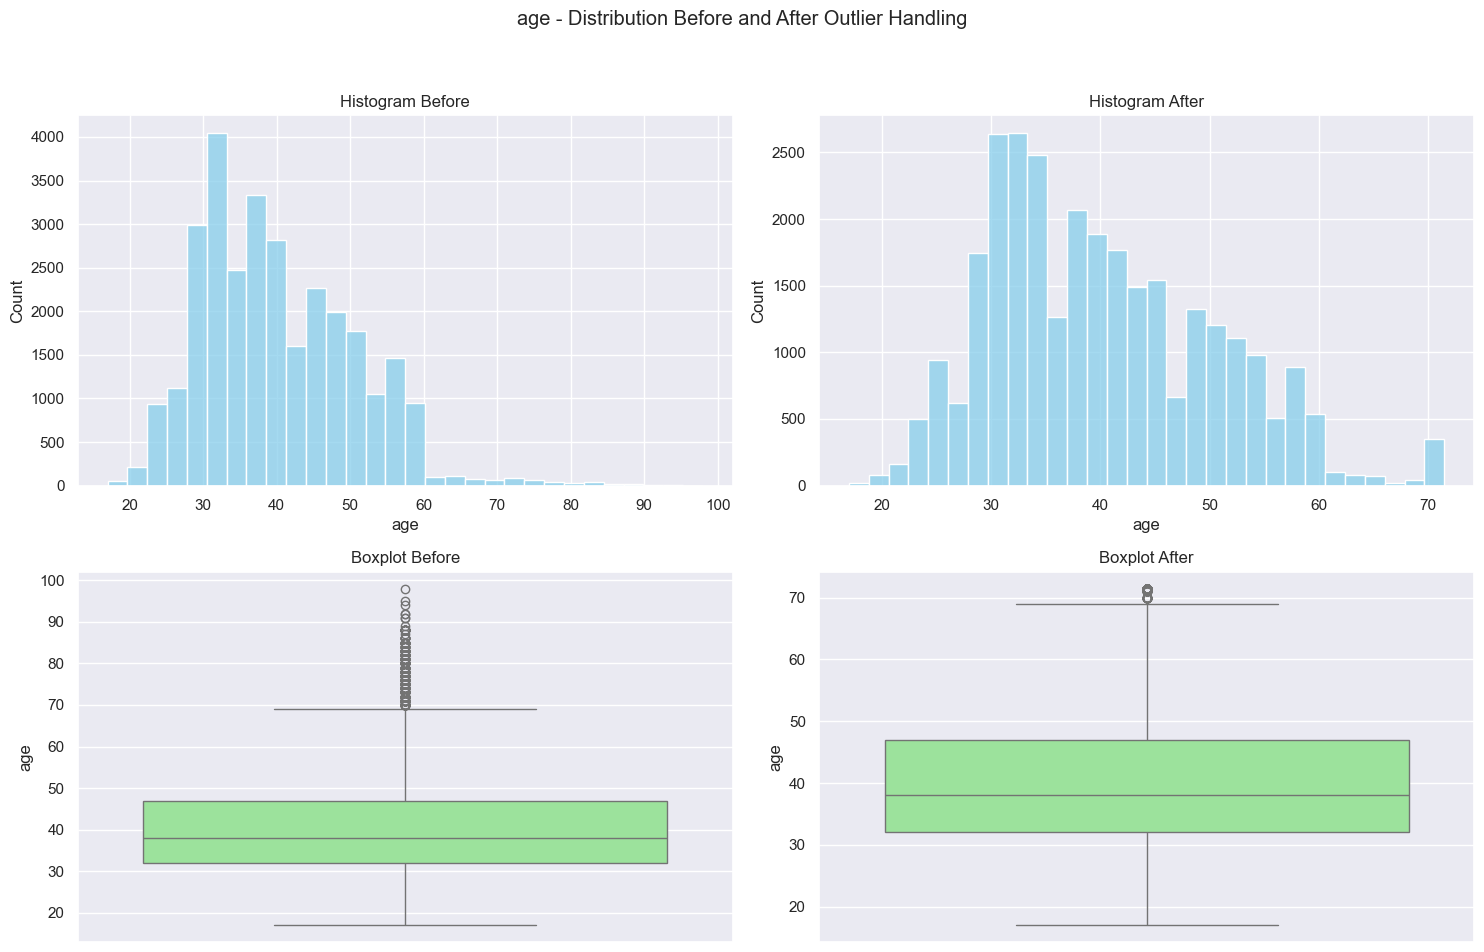

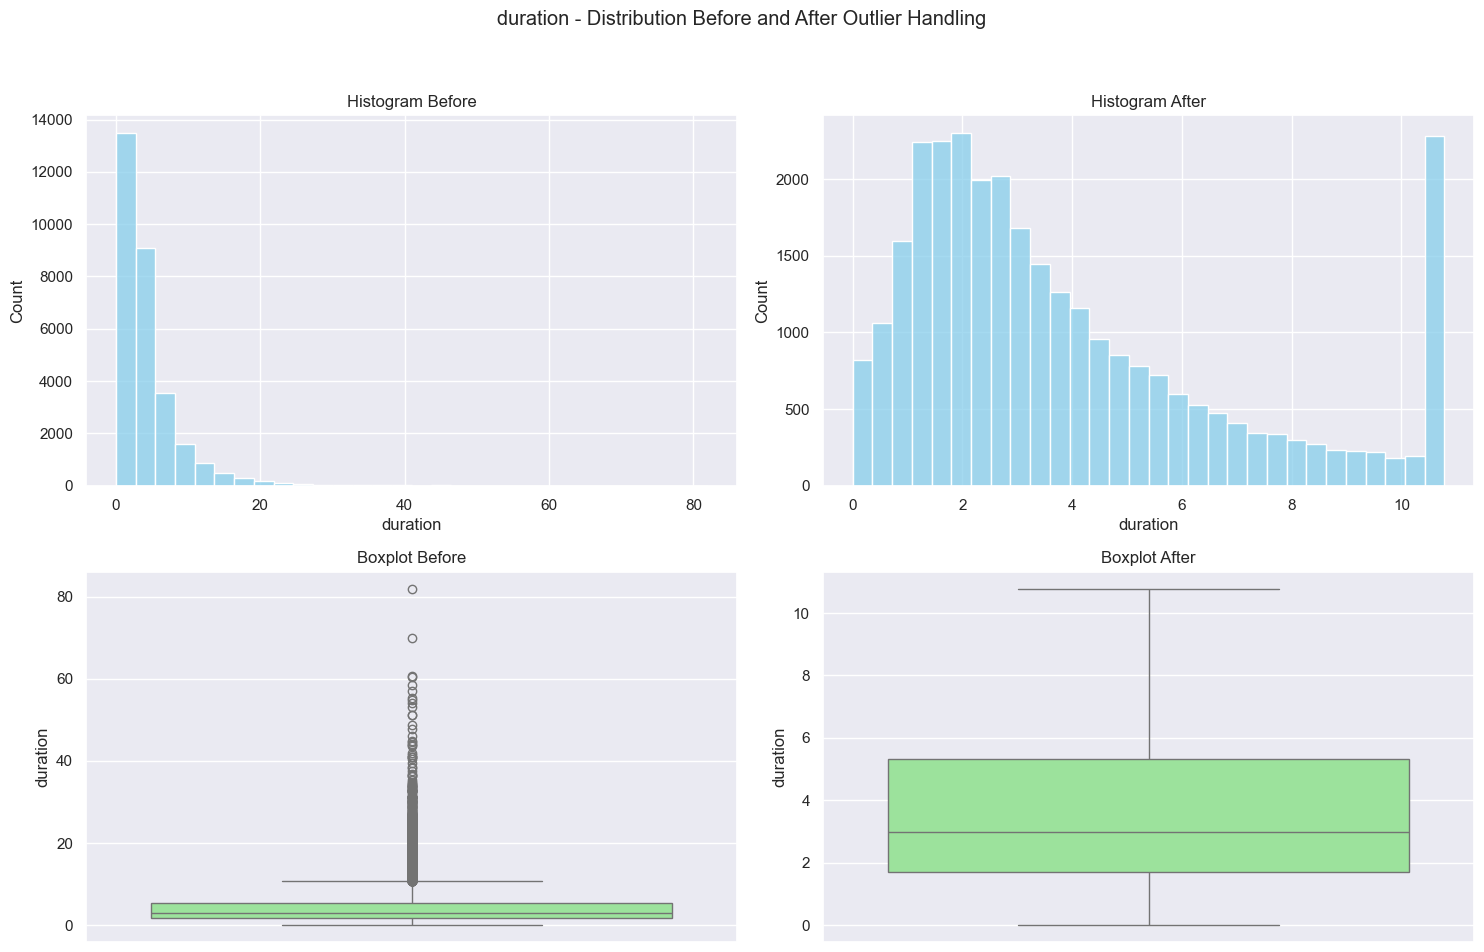

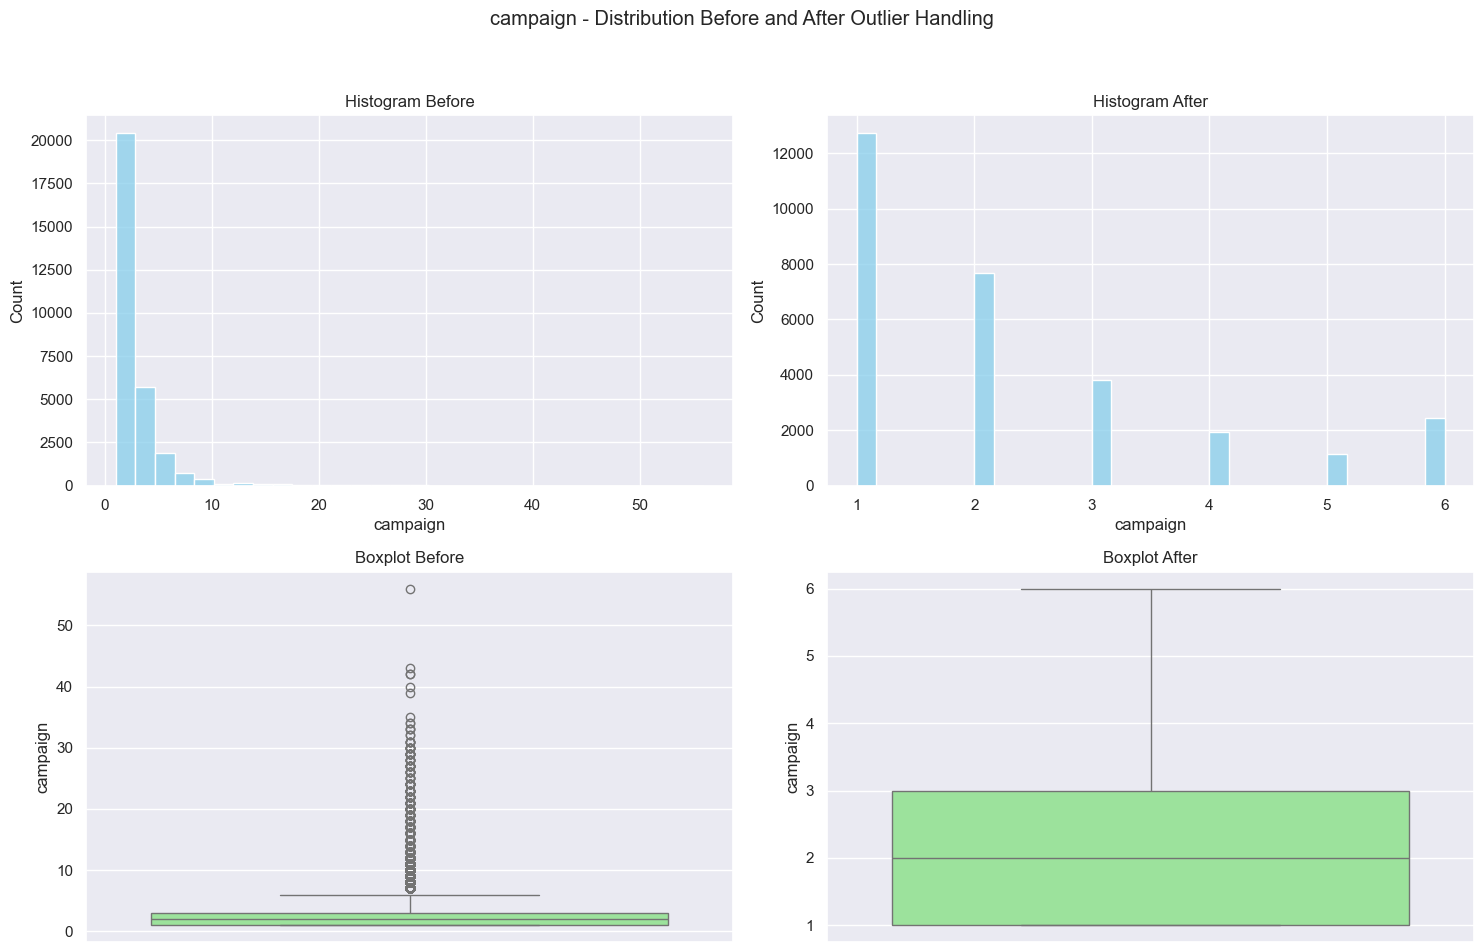

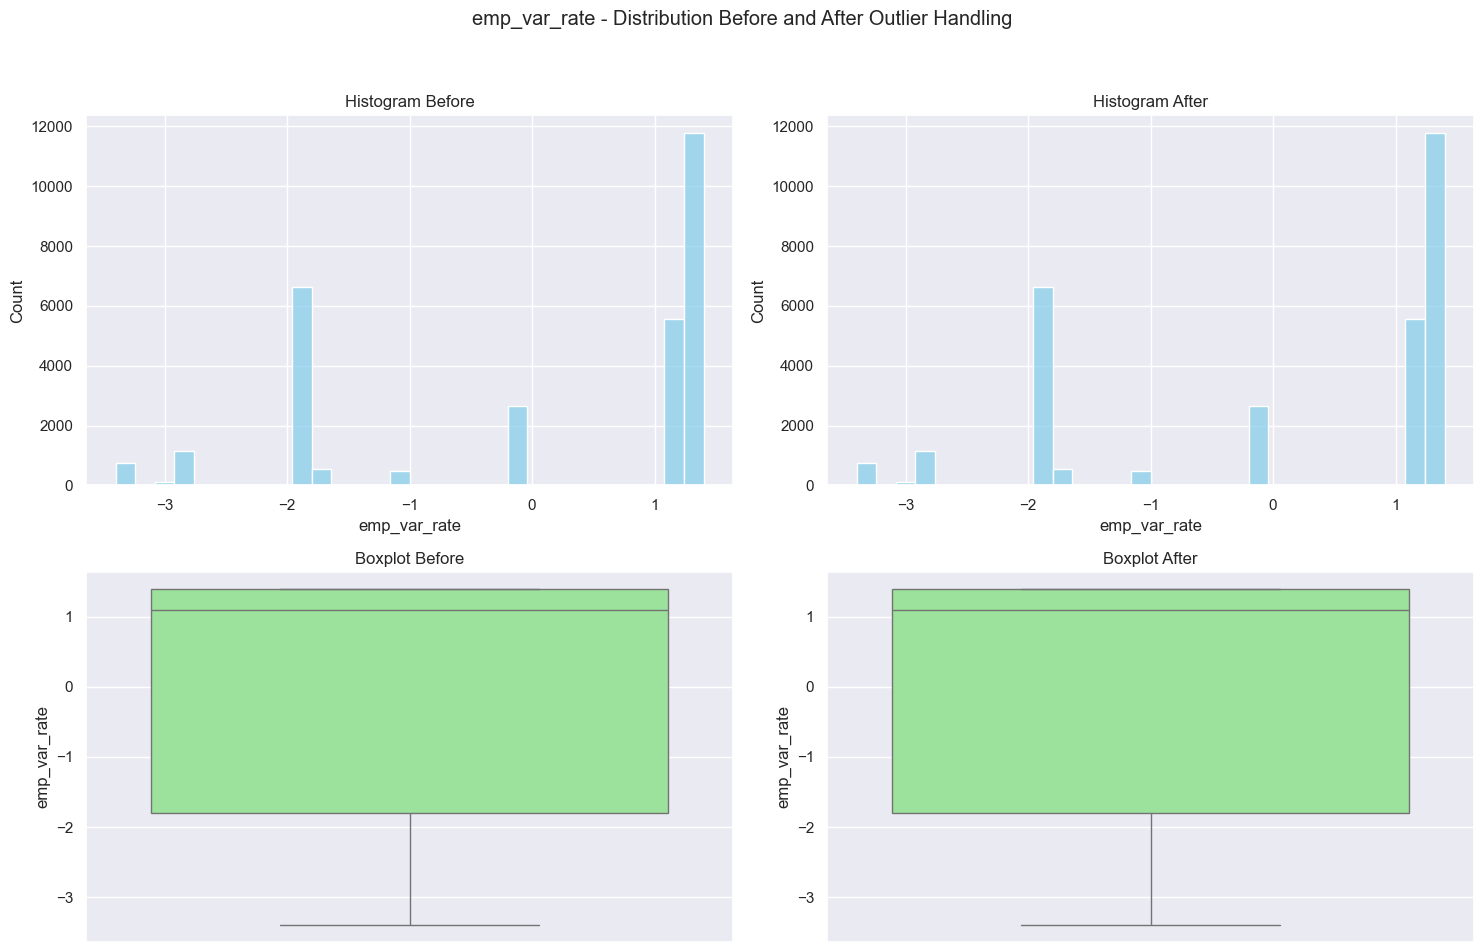

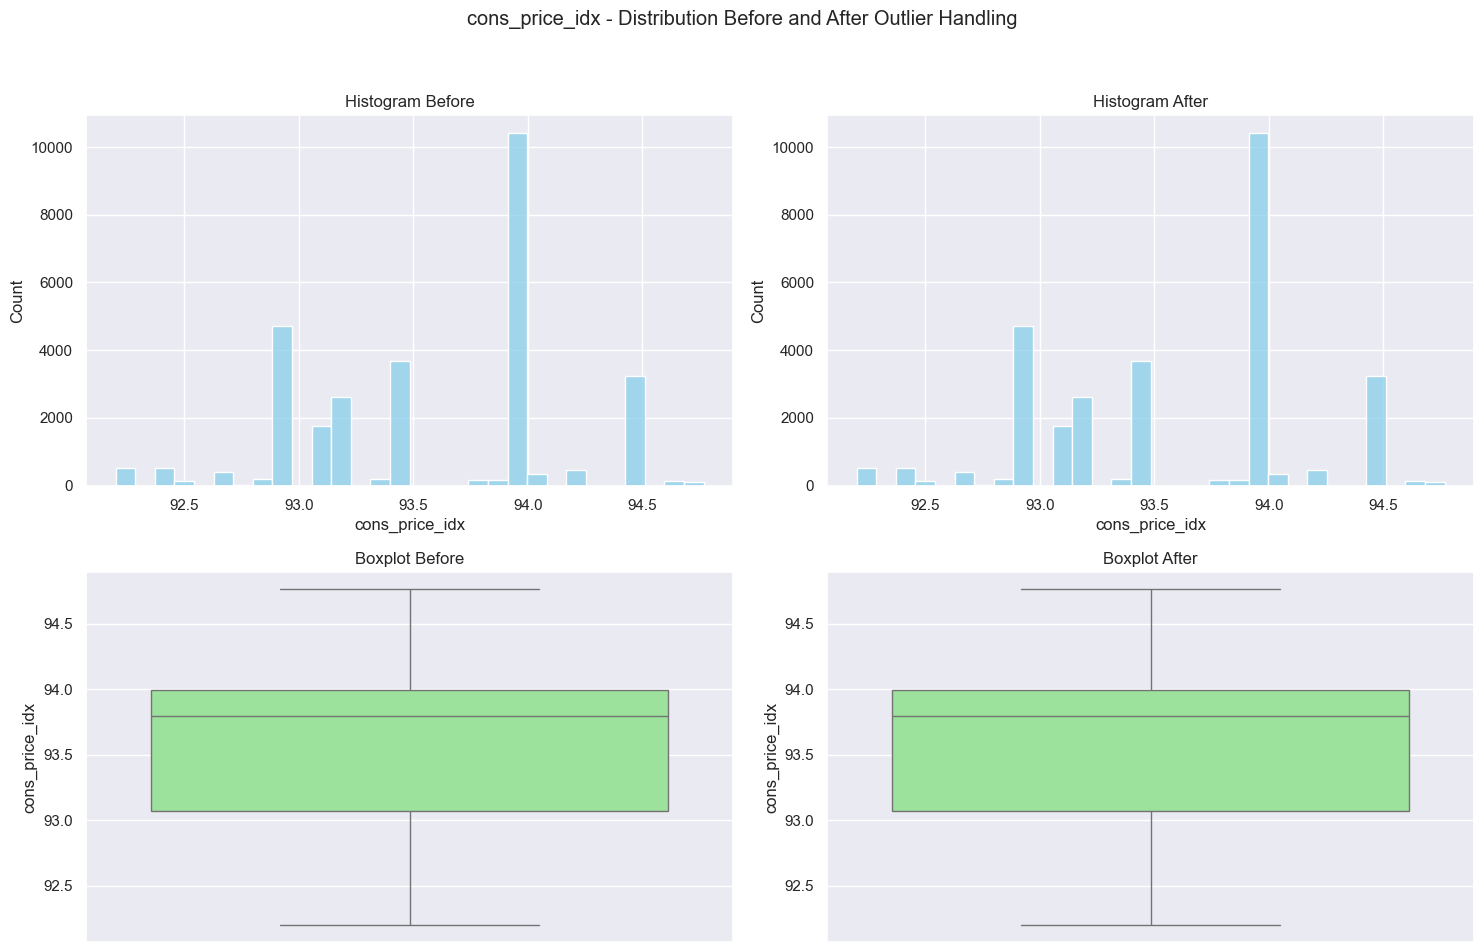

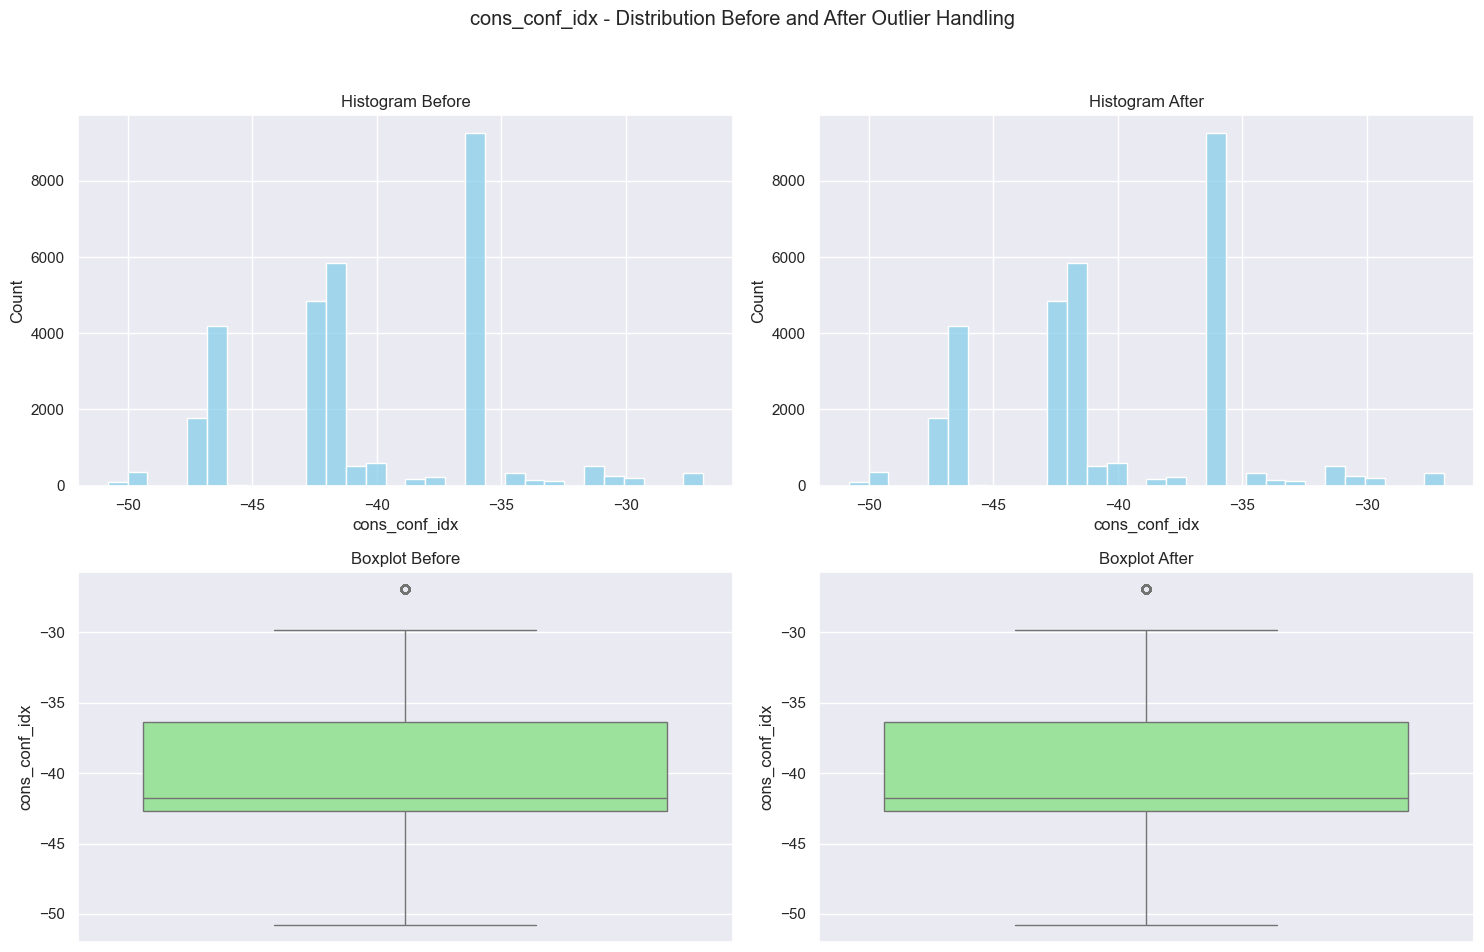

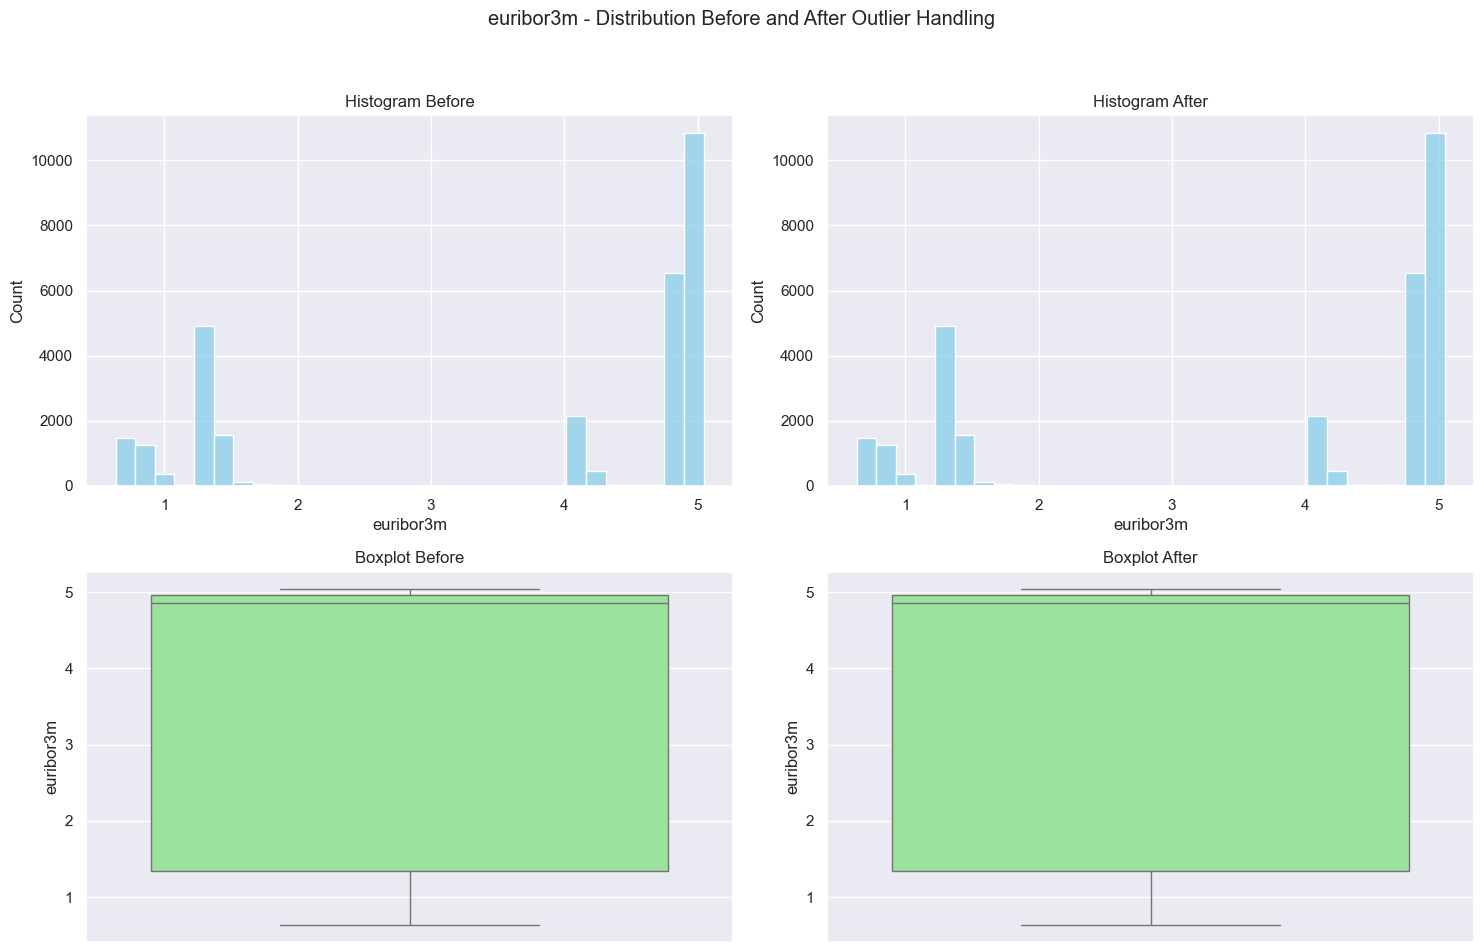

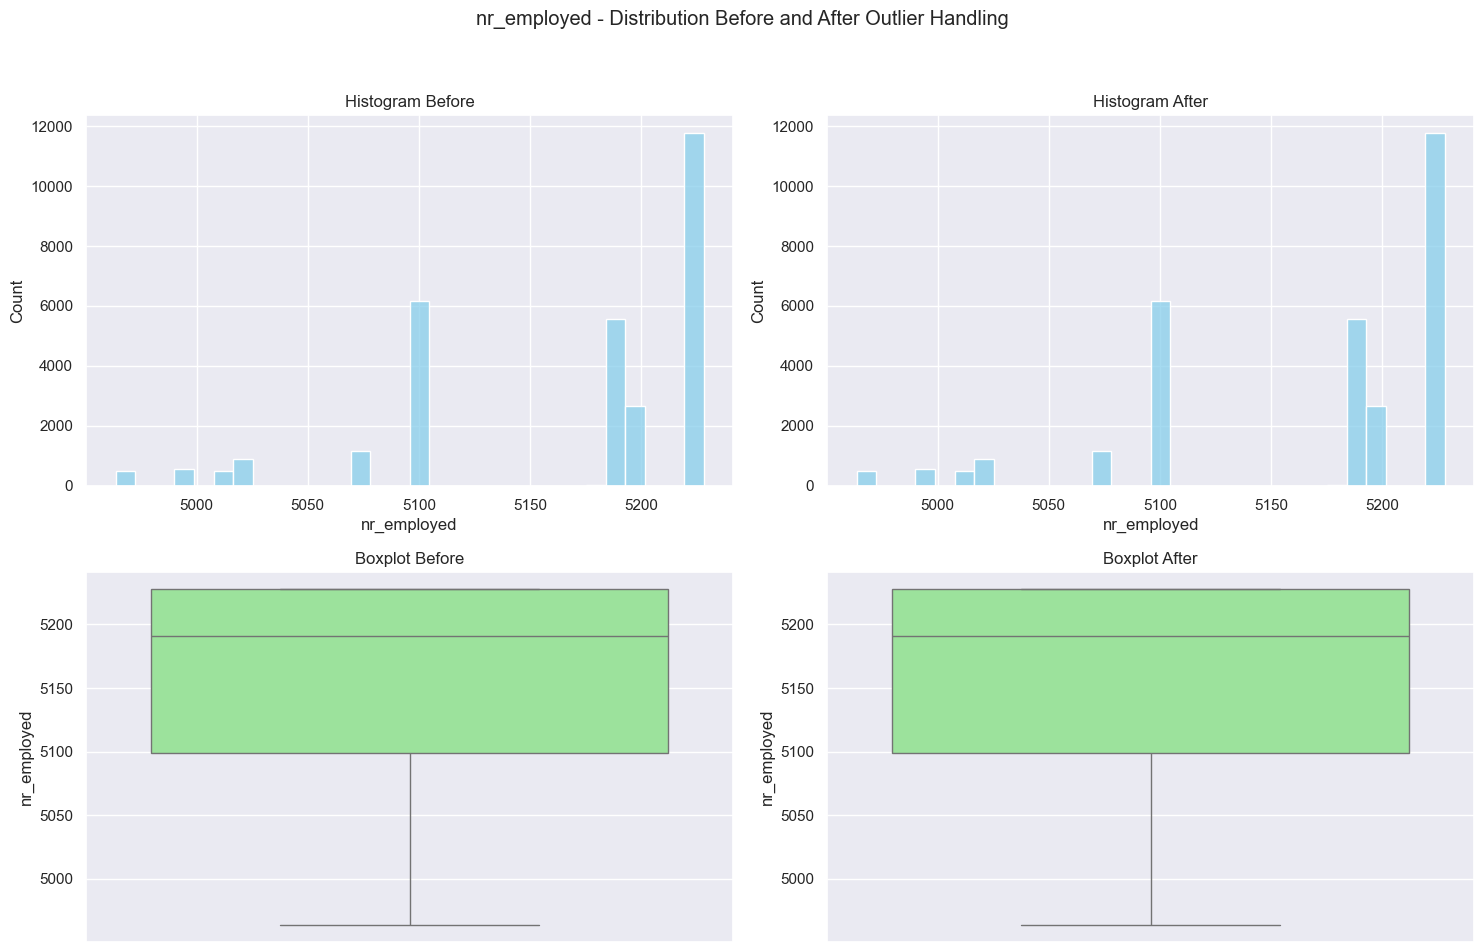

In [174]:
# Using the Function
for col in cols_outlier:
    outlier_handling_plot_comparison(X_train, X_train_capped, col)

### Feature selection 

In [175]:
# buat data list category
cat_col = X_train_capped.select_dtypes(include=['object','category']).columns.to_list()

# encode feature untuk analisis

X_train_encode = X_train_capped.copy()
X_val_encode = X_val_capped.copy()
X_test_encode = X_test_capped.copy()

for col in cat_col:
  le = LabelEncoder()
  X_train_encode[col] = le.fit_transform(X_train_encode[col])
  X_val_encode[col] = le.transform(X_val_encode[col])
  X_test_encode[col] = le.transform(X_test_encode[col])
  

In [176]:
X_train_encode.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
31570,28.0,0,2,3,0,1,0,0,6,2,3.383333,1,999,0,1,-1.8,92.893,-46.2,1.327,5099.1
19893,37.0,9,1,5,0,1,0,0,1,0,1.216667,4,999,0,1,1.4,93.444,-36.1,4.966,5228.1
25624,34.0,0,2,6,0,1,0,0,7,4,4.150000,1,999,0,1,-0.1,93.200,-42.0,4.120,5195.8
37697,33.0,0,1,3,0,0,0,0,1,4,5.350000,2,999,0,1,-2.9,92.201,-31.4,0.854,5076.2
29292,55.0,4,1,6,0,0,0,0,0,0,2.850000,2,999,0,1,-1.8,93.075,-47.1,1.405,5099.1


In [177]:
X_val_encode.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
14057,31.0,1,1,1,0,0,0,0,3,0,1.716667,2,999,0,1,1.4,93.918,-42.7,4.963,5228.1
37713,32.0,4,2,6,0,0,0,0,1,2,2.483333,1,3,2,2,-2.9,92.201,-31.4,0.851,5076.2
24275,49.0,9,1,5,0,1,0,0,7,1,4.316667,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8
5319,46.0,0,1,3,0,1,0,1,6,0,3.083333,4,999,0,1,1.1,93.994,-36.4,4.857,5191.0
32490,52.0,7,1,3,0,0,1,0,6,0,0.633333,2,999,0,1,-1.8,92.893,-46.2,1.313,5099.1


#### Univariate statistic


In [178]:
# Drop Constant Feature

# cek variance rendah
from sklearn.feature_selection import VarianceThreshold

var_tresh = VarianceThreshold(threshold=0.1)
var_tresh.fit(X_train_encode)

constant_columns = [col for col in X_train_encode.columns
                    if col not in X_train_encode.columns[var_tresh.get_support()]]

print(len(constant_columns))

print('Constant columns:', constant_columns)

1
Constant columns: ['default']


In [179]:
# drop low variance
X_train_encode.drop(constant_columns, axis=1, inplace=True)

**Correlation matrix (pearson correlation) - drop column**

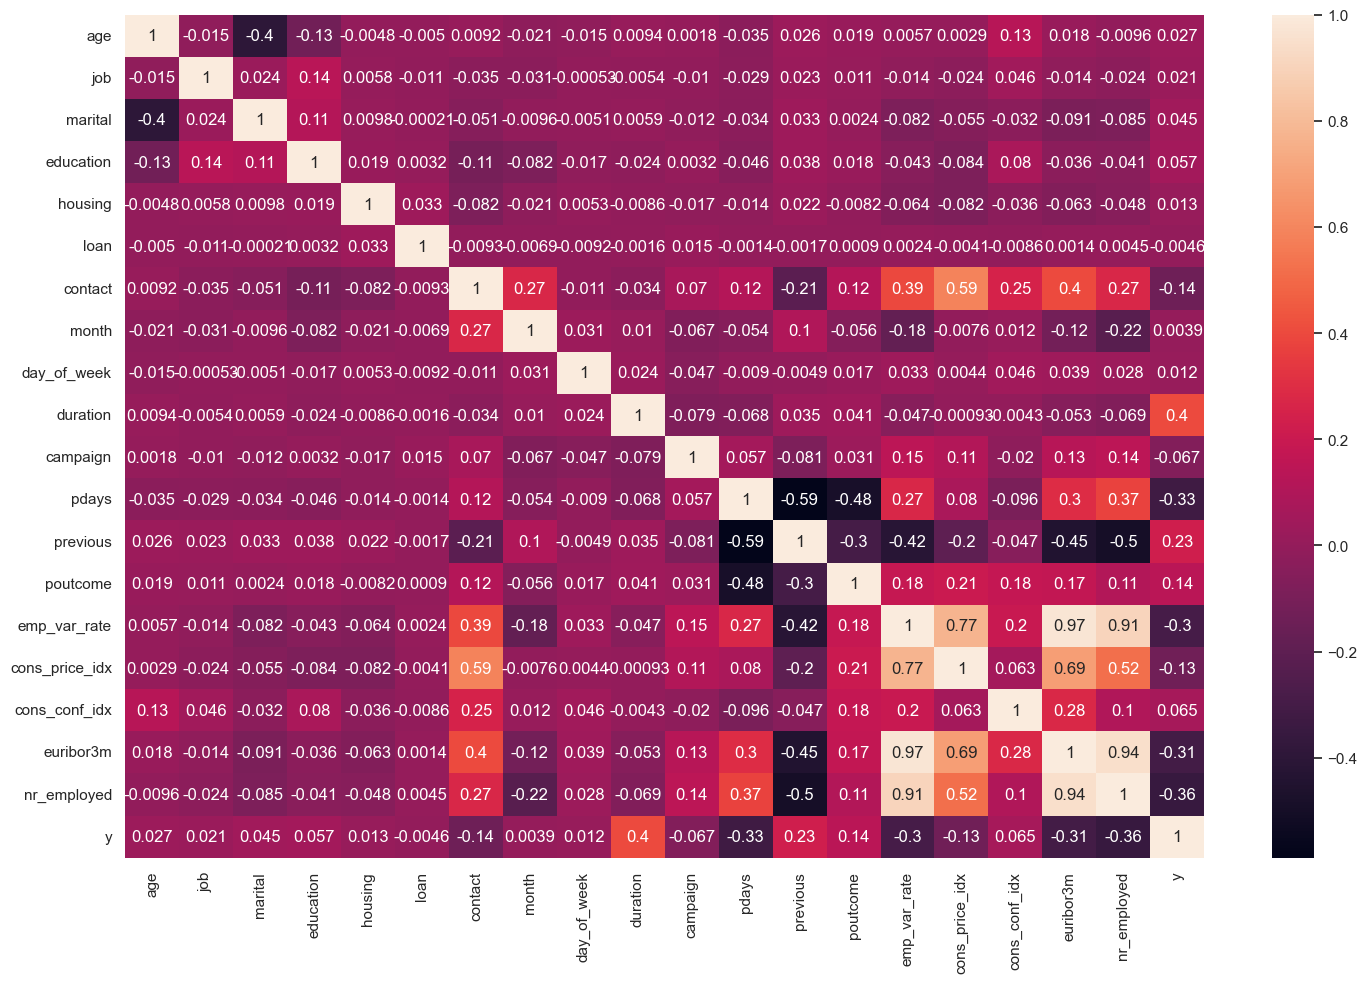

In [180]:
plt.figure(figsize=(15,10))
corr = pd.concat([X_train_encode, y_train], axis=1).corr()
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

In [181]:
def correlation(dataset, threshold):
  '''
  fungsi mencari feature yang memiliki korelasi tinggi dengan setiap kolom untuk mendeteksi fitur redundan

  parameter:

  dataset: data yang akan di cek korelasi
  threshold: nilai threshold yang ditentukan
  return: kolom yang memiliki korelasi tinggi dengan kolom lain

  penggunaan : X = correlation(X_train_num, 0.7)
  '''
  col_corr = set()
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        col_name = corr_matrix.columns[i]

        col_corr.add(col_name)
  return col_corr


feature_redundant = correlation(X_train_encode, 0.8)
feature_redundant

{'euribor3m', 'nr_employed'}

In [182]:
# Drop feature redundant
X_train_encode.drop(feature_redundant, axis=1, inplace=True)

In [183]:
X.select_dtypes(include=['object', 'category']).columns.to_list()

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [184]:
X.select_dtypes(include=np.number).columns.to_list()

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor3m',
 'nr_employed']

In [185]:
# Categorical input, categorical output treament


list_cat = ['job','marital','education','housing','loan','contact','month','day_of_week','poutcome']
X_cat = X_train_encode[list_cat]

# --- Feature Selection untuk Fitur Kategorikal dengan Chi-Square ---
from sklearn.feature_selection import SelectKBest, chi2



chi2_selector = SelectKBest(chi2, k=4)
chi2_selector.fit_transform(X_cat, y_train)

# Mendapatkan nama fitur yang dipilih dari fitur kategorikal
chi2_features = X_cat.columns[chi2_selector.get_support()].tolist()


cat_scores = chi2_selector.scores_
cat_p_values = chi2_selector.pvalues_

# Membuat DataFrame untuk hasil
cat_chi2_results = pd.DataFrame({
    'Feature': X_cat.columns,
    'Chi-Square Score': cat_scores,
    'P-Value': cat_p_values,
    'Selected': chi2_selector.get_support()
})

# # sort dataframe berdasarkan chi2 skor tinggi
cat_chi2_results = cat_chi2_results.sort_values(by='Chi-Square Score', ascending=False)

In [186]:
cat_chi2_results

,Feature,Chi-Square Score,P-Value,Selected
5,contact,373.075057,4.005589e-83,True
2,education,111.923857,3.712998e-26,True
8,poutcome,79.251888,5.467508e-19,True
0,job,45.384855,1.618813e-11,True
1,marital,18.607422,1.605941e-05,False
7,day_of_week,3.902282,4.822057e-02,False
3,housing,2.328900,1.269916e-01,False
6,month,0.565907,4.518901e-01,False
4,loan,0.531592,4.659384e-01,False


In [187]:
chi2_features

['job', 'education', 'contact', 'poutcome']

In [188]:
# Numerical input, categorical output treatment

list_num = ['age','duration','campaign','pdays','previous','emp_var_rate','cons_price_idx','cons_conf_idx']
X_num =  X_train_encode[list_num]

# --- Feature Selection untuk Fitur Numerik dengan ANOVA (F-test) ---
from sklearn.feature_selection import SelectKBest, f_classif

# Menggunakan SelectKBest dengan ANOVA
anova_selector = SelectKBest(score_func=f_classif, k=8)
anova_selector.fit_transform(X_num, y_train)

# Mendapatkan nama fitur yang dipilih dari fitur numerik
anova_features = X_num.columns[anova_selector.get_support()].tolist()

cat_scores = anova_selector.scores_
cat_p_values = anova_selector.pvalues_

# Membuat DataFrame untuk hasil
num_anova_results = pd.DataFrame({
    'Feature': X_num.columns,
    'F-Test Score': cat_scores,
    'P-Value': cat_p_values,
    'Selected': anova_selector.get_support()
})


# # sort dataframe berdasarkan  skor tinggi
num_anova_results = num_anova_results.sort_values(by='F-Test Score', ascending=False)
num_anova_results

,Feature,F-Test Score,P-Value,Selected
1,duration,5745.051935,0.000000e+00,True
3,pdays,3549.490203,0.000000e+00,True
5,emp_var_rate,2868.450979,0.000000e+00,True
4,previous,1604.414911,0.000000e+00,True
6,cons_price_idx,542.165376,7.383862e-119,True
2,campaign,133.927873,6.599261e-31,True
7,cons_conf_idx,124.344216,8.079364e-29,True
0,age,21.884096,2.908970e-06,True


In [189]:
anova_features

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx']

In [190]:
# Concat data feature
features = chi2_features + anova_features
features

['job',
 'education',
 'contact',
 'poutcome',
 'age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx']

**Feature summary**

Chi2 and f_classif ("anova") = ['job','education', 'contact', 'poutcome', 'duration', 'pdays', 'previous', 'emp_var_rate']


In [191]:
# apply feature 
X_train_selected = X_train_capped[features]
X_val_selected = X_val_capped[features]
X_test_selected = X_test_capped[features]

print(f"Train set : {X_train_selected.shape}")
print(f"Validation set : {X_val_selected.shape}")
print(f"Test set : {X_test_selected.shape}")

Train set : (29749, 12)
Validation set : (5250, 12)
Test set : (6177, 12)


In [192]:
X_train_selected.head()

,job,education,contact,poutcome,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
31570,admin.,high.school,cellular,nonexistent,28.0,3.383333,1,999,0,-1.8,92.893,-46.2
19893,technician,professional.course,cellular,nonexistent,37.0,1.216667,4,999,0,1.4,93.444,-36.1
25624,admin.,university.degree,cellular,nonexistent,34.0,4.150000,1,999,0,-0.1,93.200,-42.0
37697,admin.,high.school,cellular,nonexistent,33.0,5.350000,2,999,0,-2.9,92.201,-31.4
29292,management,university.degree,cellular,nonexistent,55.0,2.850000,2,999,0,-1.8,93.075,-47.1


In [193]:
X_val_selected.head()

,job,education,contact,poutcome,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
14057,blue-collar,basic.6y,cellular,nonexistent,31.0,1.716667,2,999,0,1.4,93.918,-42.7
37713,management,university.degree,cellular,success,32.0,2.483333,1,3,2,-2.9,92.201,-31.4
24275,technician,professional.course,cellular,nonexistent,49.0,4.316667,1,999,0,-0.1,93.200,-42.0
5319,admin.,high.school,telephone,nonexistent,46.0,3.083333,4,999,0,1.1,93.994,-36.4
32490,services,high.school,cellular,nonexistent,52.0,0.633333,2,999,0,-1.8,92.893,-46.2


In [194]:
X_test_selected.head()

,job,education,contact,poutcome,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
36264,retired,professional.course,cellular,nonexistent,59.0,10.783333,1,999,0,-2.9,92.963,-40.8
32672,blue-collar,basic.9y,cellular,failure,34.0,4.133333,1,999,1,-1.8,92.893,-46.2
40872,technician,professional.course,cellular,nonexistent,32.0,4.583333,2,999,0,-1.1,94.601,-49.5
32907,admin.,high.school,cellular,failure,53.0,3.100000,2,999,1,-1.8,92.893,-46.2
16464,services,basic.9y,telephone,nonexistent,24.0,3.066667,1,999,0,1.4,93.918,-42.7


## Preprocessing data

In [195]:
numeric_feature = X_train_selected.select_dtypes(include=np.number).columns.to_list()
numeric_feature

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx']

In [196]:
category_feature = X_train_selected.select_dtypes(include=['object', 'category']).columns.to_list()
category_feature

['job', 'education', 'contact', 'poutcome']

In [197]:
for col in category_feature:
    print(f"{col} : {X_train_selected[col].unique()}")

job : ['admin.' 'technician' 'management' 'self-employed' 'retired'
 'blue-collar' 'services' 'entrepreneur' 'housemaid' 'student'
 'unemployed']
education : ['high.school' 'professional.course' 'university.degree' 'basic.4y'
 'basic.9y' 'basic.6y' 'illiterate']
contact : ['cellular' 'telephone']
poutcome : ['nonexistent' 'failure' 'success']


In [198]:
# ordinal data
# month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
# day_of_week_order = ['mon', 'tue', 'wed', 'thu', 'fri']
education_order = ['university.degree', 
                   'high.school', 
                   'basic.9y', 
                   'professional.course',
                   'basic.4y', 
                   'basic.6y', 
                   'illiterate']

job_order = ['admin.', 
             'blue-collar', 
             'technician', 
             'services', 
             'management', 
             'retired', 
             'entrepreneur',
             'self-employed',
             'housemaid',
             'unemployed',
             'student']

ord_feature = ['job', 'education']

# nominal data
ohe_feature = ['contact', 'poutcome']

num_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", MinMaxScaler())
])

ord_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ord_enc", OrdinalEncoder(categories=[job_order, education_order]))
])

ohe_transform = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot_enc", OneHotEncoder(handle_unknown='ignore',sparse=False))
])

# column transformer

preprocessor = ColumnTransformer(
      transformers=[
          ('num', num_transform, numeric_feature),
          ('ordinal', ord_transform, ord_feature),
          ('onehot', ohe_transform, ohe_feature)
        ])

In [199]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'duration', 'campaign', 'pdays',
                                  'previous', 'emp_var_rate', 'cons_price_idx',
                                  'cons_conf_idx']),
                                ('ordinal',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord_enc',
                                                  OrdinalEncoder(categories=[['admin...
                                                                              'self-employed',
                                                                              'housemaid',
                                                                              'unemployed',
                                                                              'student'],
                                                                             ['university.degree',
                                                                              'high.school',
                                                                              'basic.9y',
                                                                              'professional.course',
                                                                              'basic.4y',
                                                                              'basic.6y',
                                                                              'illiterate']]))]),
                                 ['job', 'education']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot_enc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['contact', 'poutcome'])])

In [200]:
X_train_preproc = preprocessor.fit_transform(X_train_selected)
X_val_preproc = preprocessor.transform(X_val_selected)
X_test_preproc = preprocessor.transform(X_test_selected)

### Balancing data

In [201]:
print("Label class: {}".format(Counter(y_train)))
counter = Counter(y_train)

Label class: Counter({0: 26425, 1: 3324})


In [202]:
seed = 42
np.random.seed(seed)
smote = SMOTE(random_state=seed)

# imbalance handling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preproc, y_train)
print("Label class with balancing data: {}".format(Counter(y_train_resampled)))


Label class with balancing data: Counter({0: 26425, 1: 26425})


# Build Model

In [205]:
# parameter

n_input = X_train_resampled.shape[1]

n_batch_size = 16

n_steps_per_epoch = int(X_train_resampled.shape[0] / n_batch_size)
n_validation_steps = int(X_val_preproc.shape[0] / n_batch_size)
n_test_steps = int(X_test_preproc.shape[0]/ n_batch_size)

n_epochs = 25

print("Input shape : {}".format(n_input))
print("Batch size : {}".format(n_batch_size))
print("\nSteps per epoch : {}".format(n_steps_per_epoch))
print("\nValidation steps : {}".format(n_validation_steps))
print("Test steps : {}".format(n_test_steps))
print("\nNumber per Epochs : {}".format(n_epochs))


Input shape : 15
Batch size : 16

Steps per epoch : 3303

Validation steps : 328
Test steps : 386

Number per Epochs : 25


In [278]:
# clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)



# create model base
base_model = Sequential()
base_model.add(Dense(12, activation='relu', input_shape=(n_input,)))
base_model.add(Dense(8, activation='relu'))
base_model.add(Dense(1, activation='sigmoid'))
#compile base_model
base_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
base_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                192       
                                                                 
 dense_1 (Dense)             (None, 8)                 104       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 305 (1.19 KB)
Trainable params: 305 (1.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
PATH_DIR = "./model_and_param/model_checkpoint"
if not os.path.exists(PATH_DIR):
    os.makedirs(PATH_DIR)

def get_unique_filename(directory, base_filename, extension):
    counter = 1
    filename = f"{base_filename}.{extension}"
    while os.path.exists(os.path.join(directory, filename)):
        filename = f"{base_filename}_{counter}.{extension}"
        counter += 1
    return filename

file_name = get_unique_filename(PATH_DIR, "model_ann", "h5")
# callbacks
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(PATH_DIR, file_name),
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True  # Hanya menyimpan model jika ada perbaikan pada val_loss
)
# early stoping
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [280]:
# Training model

history = base_model.fit(X_train_resampled, 
                        y_train_resampled,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(X_val_preproc, y_val),
                        validation_steps=n_validation_steps,
                        callbacks=[model_checkpoint])


Epoch 1/25
1621/1651 [============================>.] - ETA: 0s - loss: 0.4187 - accuracy: 0.8089
Epoch 1: val_accuracy improved from -inf to 0.82660, saving model to ./model_and_param/model_checkpoint\model_ann_4.h5
1651/1651 [==============================] - 4s 2ms/step - loss: 0.4171 - accuracy: 0.8099 - val_loss: 0.3668 - val_accuracy: 0.8266
Epoch 2/25
1635/1651 [============================>.] - ETA: 0s - loss: 0.3097 - accuracy: 0.8733
Epoch 2: val_accuracy improved from 0.82660 to 0.82908, saving model to ./model_and_param/model_checkpoint\model_ann_4.h5
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3102 - accuracy: 0.8731 - val_loss: 0.3531 - val_accuracy: 0.8291
Epoch 3/25
1622/1651 [============================>.] - ETA: 0s - loss: 0.3048 - accuracy: 0.8755
Epoch 3: val_accuracy did not improve from 0.82908
1651/1651 [==============================] - 3s 2ms/step - loss: 0.3045 - accuracy: 0.8757 - val_loss: 0.3704 - val_accuracy: 0.8264
Epoch 4/25
1644

In [281]:
# evaluate model training data
loss, acc = base_model.evaluate(X_train_resampled, y_train_resampled)
print("Accuracy score training data : {:.4f}".format(acc))
print("Loss Score : {:.4f}".format(loss))

1652/1652 [==============================] - 3s 2ms/step - loss: 0.2829 - accuracy: 0.8839
Accuracy score training data : 0.8839
Loss Score : 0.2829


In [284]:
# Predicting the Test set results
y_pred = base_model.predict(X_test_preproc)
y_pred = (y_pred > 0.5)


# evaluate model test data
loss, acc = base_model.evaluate(X_test_preproc, y_test)
print("Accuracy score Test data : {:.4f}".format(acc))
print("Loss Score : {:.4f}".format(loss))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix - :\n{cm}\n')
# classification report
print(f'\nClassification Report - :\n{classification_report(y_test, y_pred)}')

194/194 [==============================] - 0s 2ms/step - loss: 0.3647 - accuracy: 0.8243
Accuracy score Test data : 0.8243
Loss Score : 0.3647
Confusion Matrix - :
[[4456 1005]
 [  80  636]]


Classification Report - :
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      5461
           1       0.39      0.89      0.54       716

    accuracy                           0.82      6177
   macro avg       0.68      0.85      0.72      6177
weighted avg       0.91      0.82      0.85      6177



In [285]:
# Evaluate
hist_df = pd.DataFrame(history.history)
hist_df['n_epochs'] = hist_df.index
hist_df

,loss,accuracy,val_loss,val_accuracy,n_epochs
0,0.417061,0.809888,0.366844,0.826601,0
1,0.310157,0.873055,0.353087,0.829078,1
2,0.304488,0.875705,0.370397,0.826410,2
3,0.302326,0.876160,0.359097,0.826601,3
4,0.299380,0.875781,0.323988,0.841463,4
5,0.296648,0.876860,0.327385,0.838986,5
6,0.295131,0.877561,0.347237,0.832317,6
7,0.293377,0.878204,0.313793,0.844322,7
8,0.291981,0.879132,0.322047,0.840320,8
9,0.290686,0.879889,0.324791,0.837843,9


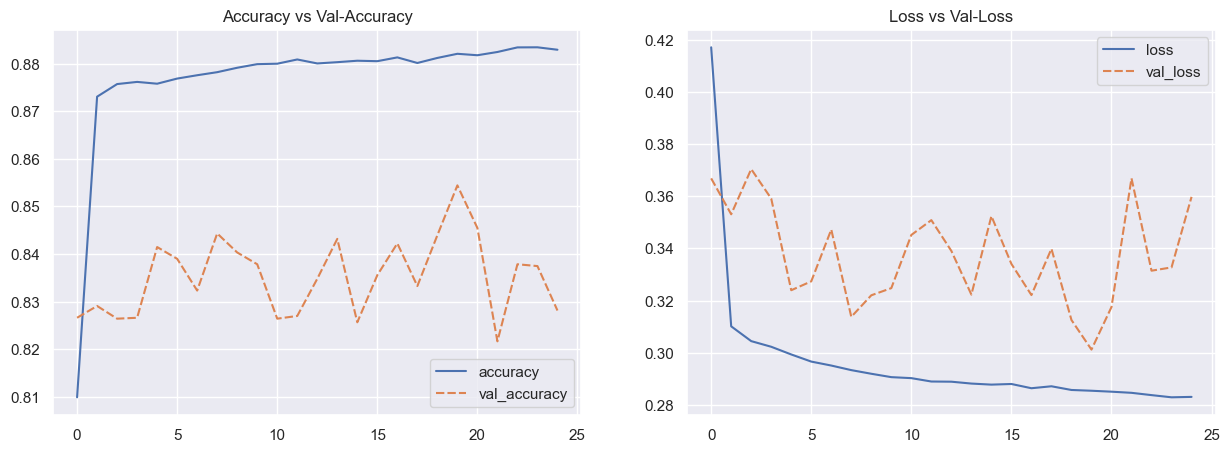

In [286]:
# Plot Training Results
hist_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=hist_df[['accuracy', 'val_accuracy']])
plt.grid(True)
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=hist_df[['loss', 'val_loss']])
plt.grid(True)
plt.title('Loss vs Val-Loss')


plt.show()

Masalah ANN paling umum adalah Overfitting seperti di grafik accuracy train sekitar 88%-89% sedangkan validasi set stagnan 82%-85% memilki selisih cukup besar di tambah loss yang stagnan juga.

In [272]:
# fungsi evaluasi model Precision-Recall Curve dan ROC AUC.

from sklearn.metrics import precision_recall_curve, average_precision_score

def evaluate_models(model, X_test, y_test, thresholds=0.5):
    """
    Evaluates multiple models on the test data using Precision-Recall Curve and ROC AUC.

    Args:
        models (dict): A dictionary where keys are model names and values are model objects.
        X_test (array-like): Test features.
        y_test (array-like): True labels for the test set.

    Returns:
        None
    """
    plt.figure(figsize=(14, 6))

    # Plot ROC Curve
    plt.subplot(1, 2, 1)
    # Predict probabilities
    y_scores = model.predict(X_test_preproc)
    # y_pred = (y_pred > thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'Model ANN (AUC: {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid(True)

    # Plot Precision-Recall Curve
    plt.subplot(1, 2, 2)
    # Predict probabilities
    y_scores = model.predict(X_test_preproc)
    # y_pred = (y_pred > thresholds)
    precision, recall, thresholds, = precision_recall_curve(y_test, y_scores)
    pr_auc = average_precision_score(y_test, y_scores)
    # Plot Precision-Recall Curve
    plt.plot(recall, precision, label=f'Model ANN (AP: {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid(True)

    # Plot ROC Curve
    plt.subplot(1, 2, 2)
    # Predict probabilities
    y_scores = model.predict(X_test_preproc)
    # y_pred = (y_pred > thresholds)
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    # Plot ROC Curve
    plt.plot(fpr, tpr, label=f'Model ANN (AUC: {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # Diagonal line for random guess
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Print Precision, Recall, and ROC AUC scores
    y_scores = model.predict(X_test)
    pr_auc = average_precision_score(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    print("-"*50)
    print(f'Model ANN - : \nPrecision-Recall AUC: {pr_auc:.2f} \nROC AUC: {roc_auc:.2f}')


194/194 [==============================] - 0s 2ms/step


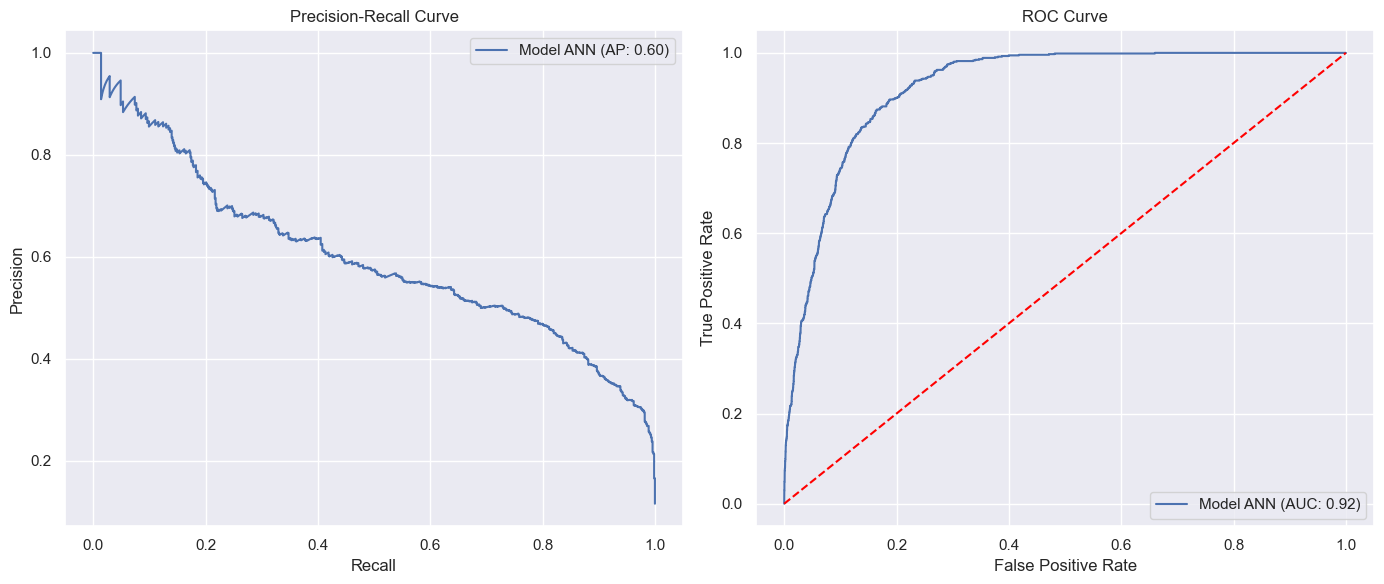

194/194 [==============================] - 0s 2ms/step
--------------------------------------------------
Model ANN - : 
Precision-Recall AUC: 0.60 
ROC AUC: 0.92


In [287]:
evaluate_models(model=base_model, X_test=X_test_preproc, y_test=y_test)

### Model Improvement

In [273]:
# model improvement
# parameter

input_shape = X_train_resampled.shape[1]

n_batch_size = 32

n_steps_per_epoch = int(X_train_resampled.shape[0] / n_batch_size)
n_validation_steps = int(X_val_preproc.shape[0] / n_batch_size)
n_test_steps = int(X_test_preproc.shape[0]/ n_batch_size)

n_epochs = 25

print("Input shape : {}".format(input_shape))
print("Batch size : {}".format(n_batch_size))
print("\nSteps per epoch : {}".format(n_steps_per_epoch))
print("\nValidation steps : {}".format(n_validation_steps))
print("Test steps : {}".format(n_test_steps))
print("\nNumber per Epochs : {}".format(n_epochs))

Input shape : 15
Batch size : 32

Steps per epoch : 1651

Validation steps : 164
Test steps : 193

Number per Epochs : 25


**Improve model with smaller neuron and cross-validation**

In [268]:
# Model update
def model_improve():
    # clear session
    seed = 20
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # create model
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=HeNormal(seed), input_shape=(input_shape,)))
    model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed)))

    #compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.summary()
    return model


In [269]:
# using Keras clf
kfold = StratifiedKFold(n_splits=10, shuffle=True)

ann_model = KerasClassifier(build_fn=model_improve, batch_size=n_batch_size, epochs=n_epochs, verbose=0)

cv_accuracy = cross_val_score(estimator=ann_model, X = X_train_resampled, y=y_train_resampled, cv=kfold, )
# print(f'Accuracy Score : {accuracy_score(y_val, y_pred):.4f}')
print(f"CV Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(cv_accuracy)      

CV Accuracy: 0.8780 ± 0.0031
[0.87965941 0.87833491 0.87871334 0.87530747 0.88022706 0.87322611
 0.88041627 0.87549669 0.88401135 0.87455061]


hasil cross validation menunjukkan 87% dengan std kecil 0.0031

**Add Dropout**

In [295]:
# parameter

input_shape = X_train_resampled.shape[1]

n_batch_size = 16

n_steps_per_epoch = int(X_train_resampled.shape[0] / n_batch_size)
n_validation_steps = int(X_val_preproc.shape[0] / n_batch_size)
n_test_steps = int(X_test_preproc.shape[0]/ n_batch_size)

n_epochs = 50

print("Input shape : {}".format(input_shape))
print("Batch size : {}".format(n_batch_size))
print("\nSteps per epoch : {}".format(n_steps_per_epoch))
print("\nValidation steps : {}".format(n_validation_steps))
print("Test steps : {}".format(n_test_steps))
print("\nNumber per Epochs : {}".format(n_epochs))

Input shape : 15
Batch size : 16

Steps per epoch : 3303

Validation steps : 328
Test steps : 386

Number per Epochs : 50


In [296]:
# Model update

# clear session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)
# create model
model_update = Sequential()
model_update.add(Dense(8, activation='relu', kernel_initializer=HeNormal(seed), input_shape=(input_shape,)))
model_update.add(Dropout(0.2))
model_update.add(Dense(4, activation='relu', kernel_regularizer=l2(0.01)))
model_update.add(Dropout(0.1))
model_update.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed)))
#compile model_update
model_update.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summary
model_update.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 128       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 169 (676.00 Byte)
Trainable params: 169 (676.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [297]:
# Training models

history_1 = model_update.fit(X_train_resampled, 
                        y_train_resampled,
                        steps_per_epoch=n_steps_per_epoch,
                        epochs=n_epochs,
                        batch_size=n_batch_size,
                        validation_data=(X_val_preproc, y_val),
                        validation_steps=n_validation_steps,
                        callbacks=[model_checkpoint])


Epoch 1/50
3300/3303 [============================>.] - ETA: 0s - loss: 0.5294 - accuracy: 0.7737
Epoch 1: val_accuracy did not improve from 0.85442
3303/3303 [==============================] - 8s 2ms/step - loss: 0.5292 - accuracy: 0.7739 - val_loss: 0.4717 - val_accuracy: 0.8361
Epoch 2/50
3299/3303 [============================>.] - ETA: 0s - loss: 0.4266 - accuracy: 0.8315
Epoch 2: val_accuracy did not improve from 0.85442
3303/3303 [==============================] - 7s 2ms/step - loss: 0.4267 - accuracy: 0.8314 - val_loss: 0.4056 - val_accuracy: 0.8540
Epoch 3/50
3292/3303 [============================>.] - ETA: 0s - loss: 0.4057 - accuracy: 0.8380
Epoch 3: val_accuracy did not improve from 0.85442
3303/3303 [==============================] - 7s 2ms/step - loss: 0.4058 - accuracy: 0.8380 - val_loss: 0.3973 - val_accuracy: 0.8542
Epoch 4/50
3293/3303 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8405
Epoch 4: val_accuracy did not improve from 0.85442
3303/

In [300]:
# Predicting the training set results
y_pred = model_update.predict(X_train_resampled)
y_pred = (y_pred > 0.5)

# evaluate model training data
loss, acc = model_update.evaluate(X_train_resampled, y_train_resampled)
print("Accuracy score training data : {:.4f}".format(acc))
print("Loss Score : {:.4f}".format(loss))

# confusion matrix
cm = confusion_matrix(y_train_resampled, y_pred)
print(f'Confusion Matrix - :\n{cm}\n')
# classification report
print(f'\nClassification Report - :\n{classification_report(y_train_resampled, y_pred)}')

1652/1652 [==============================] - 3s 2ms/step - loss: 0.3360 - accuracy: 0.8745
Accuracy score training data : 0.8745
Loss Score : 0.3360
Confusion Matrix - :
[[22526  3899]
 [ 2734 23691]]


Classification Report - :
              precision    recall  f1-score   support

           0       0.89      0.85      0.87     26425
           1       0.86      0.90      0.88     26425

    accuracy                           0.87     52850
   macro avg       0.88      0.87      0.87     52850
weighted avg       0.88      0.87      0.87     52850



In [309]:
# Predicting the Test set results
y_pred = model_update.predict(X_test_preproc)
y_pred = (y_pred > 0.8)


# evaluate model test data
loss, acc = model_update.evaluate(X_test_preproc, y_test)
print("Accuracy score Test data : {:.4f}".format(acc))
print("Loss Score : {:.4f}".format(loss))

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix - :\n{cm}\n')
# classification report
print(f'\nClassification Report - :\n{classification_report(y_test, y_pred)}')

194/194 [==============================] - 0s 2ms/step - loss: 0.3896 - accuracy: 0.8490
Accuracy score Test data : 0.8490
Loss Score : 0.3896
Confusion Matrix - :
[[5155  306]
 [ 295  421]]


Classification Report - :
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      5461
           1       0.58      0.59      0.58       716

    accuracy                           0.90      6177
   macro avg       0.76      0.77      0.76      6177
weighted avg       0.90      0.90      0.90      6177



194/194 [==============================] - 0s 2ms/step


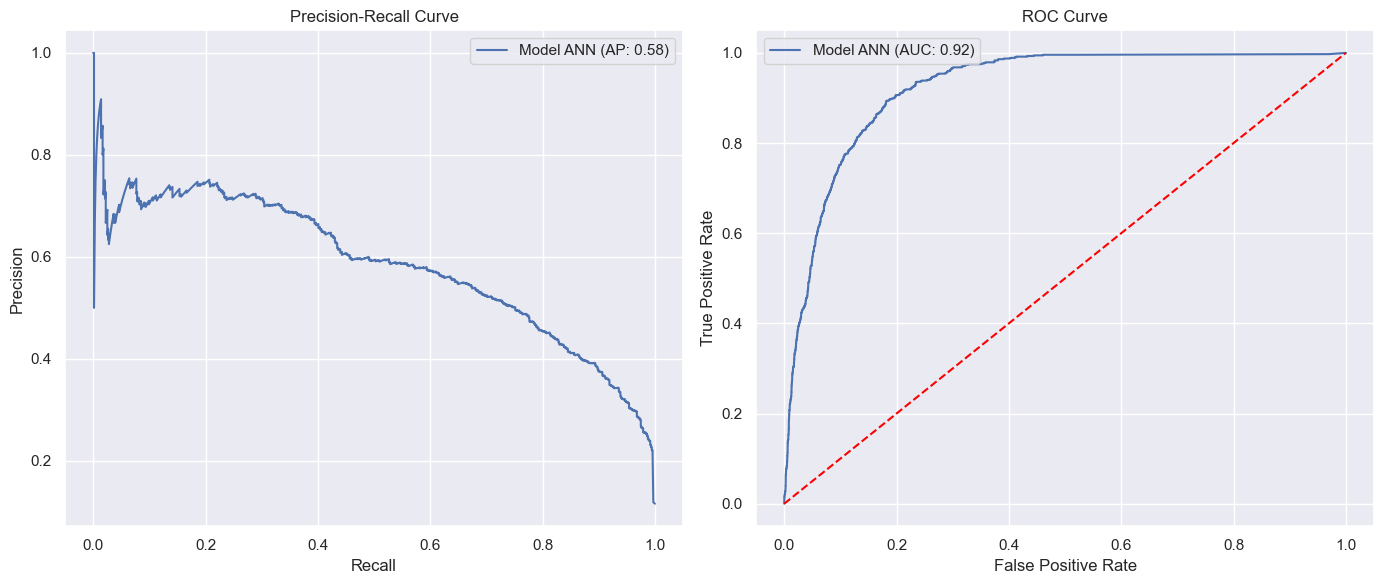

194/194 [==============================] - 0s 2ms/step
--------------------------------------------------
Model ANN - : 
Precision-Recall AUC: 0.58 
ROC AUC: 0.92


In [306]:
evaluate_models(model_update, X_test_preproc, y_test)

**Tuning mode with Grid search**

In [325]:
def model_improve_grids(optimizer='adam'):
    # clear session
    seed = 20
    tf.keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # create model
    model = Sequential()
    model.add(Dense(8, activation='relu', kernel_initializer=HeNormal(seed), input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=GlorotUniform(seed)))

    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [326]:
# parameter
parameters = {'batch_size': [24, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}

In [327]:
# init keras wrapper
classifier = KerasClassifier(build_fn = model_improve_grids)


# apply grids
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = kfold)

# fitting grid
grid_search = grid_search.fit(X_train_resampled, y_train_resampled,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Model ANN - Best Parameters:")
pprint(best_parameters)
print(f"Best Score: {best_accuracy:.4f}")

166/166 [==============================] - 1s 3ms/step


KeyboardInterrupt: 